In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
df = pd.read_csv('fashion-mnist_train.csv')
df

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
59996,1,0,0,0,0,0,0,0,0,0,...,73,0,0,0,0,0,0,0,0,0
59997,8,0,0,0,0,0,0,0,0,0,...,160,162,163,135,94,0,0,0,0,0
59998,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
y_train = df['label']
x_train = df.drop(columns=['label'])
X_train = x_train.values
Y_train = y_train.values

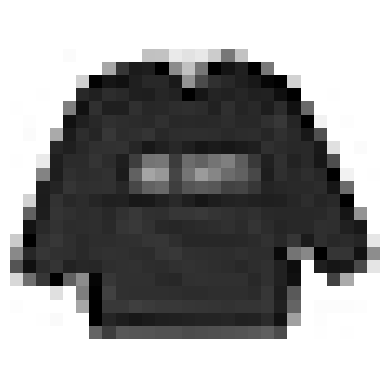

In [4]:
image = X_train[0].reshape(28,28) # Reshape the image from (784,) to (28, 28)
plt.imshow(image, cmap="binary")
plt.axis('off')
plt.show()

In [5]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]
class_names[y_train[0]]

'Pullover'

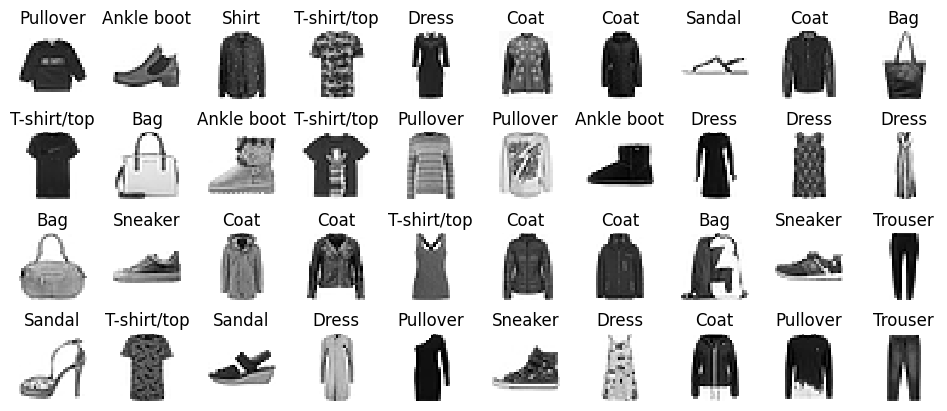

In [6]:
n_rows = 4
n_cols = 10
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train[index].reshape(28,28), cmap="binary", interpolation="nearest")
        plt.axis('off')
        plt.title(class_names[y_train[index]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

In [7]:
df = np.array(df) # converting dataset to an array, to perform linear algebra on it
m, n = df.shape
data = df.T # Tranposing the array (Each column is an example, instead of each row being an example)
Y_train = data[0]
X_train = data[1:n]
X_train = X_train / np.max(X_train) # Normalize X_train
X_train.shape

(784, 60000)

In [8]:
def init_params():
    W1 = np.random.randn(10, 784) * np.sqrt(1 / 784) # Scaled for gradient stability (randn generates random values between -0.5 and +0.5)
    b1 = np.random.randn(10, 1) * np.sqrt(1 / 10)
    W2 = np.random.randn(10, 10)
    b2 = np.random.randn(10, 1)  
    return W1, b1, W2, b2

def ReLU(Z): # Rectified Linear Unit (Activation Function for hidden layer (makes model complex and powerful)) {x if x>0, 0 if x<=0}
    return np.maximum(0.01*Z, Z) #(leaky RelU, if most activations = 0 then wont learn effectively)

def softmax(Z): 
    #(Activation function for output layer) Each node(in output layer) corresponds to each of the digit it could be recognised as
    Z_exp = np.exp(Z - np.max(Z, axis=0, keepdims=True))
    return Z_exp / np.sum(Z_exp, axis=0, keepdims=True)
    # Gives Probabilty for each node which corresponds to one of the 10 digits that it could be

def forward_prop(W1, b1, W2, b2, X):
    Z1 = W1.dot(X) + b1
    A1 = ReLU(Z1)
    Z2 = W2.dot(A1) + b2
    A2 = softmax(Z2) 
    return Z1, A1, Z2, A2

def ReLU_deriv(Z):
    return Z > 0 # True = 1, False = 0  

def one_hot(Y): # one hot encoding Y array
    one_hot_Y = np.zeros((Y.size, Y.max() + 1)) 
    # Creates a new matrix of 0's (one_hot_Y), Y.size = m, Y.max()+1 will give 10 which is the number of out output class  
    one_hot_Y[np.arange(Y.size), Y] = 1 
    # for each row go to the column specified by the label in Y and set it to 1
    one_hot_Y = one_hot_Y.T
    return one_hot_Y

def backward_prop(Z1, A1, Z2, A2, W1, W2, X, Y):
    m = Y.size  # Number of samples
    one_hot_Y = one_hot(Y)
    dZ2 = A2 - one_hot_Y
    dW2 = 1 / m * dZ2.dot(A1.T)
    db2 = 1 / m * np.sum(dZ2, axis=1, keepdims=True)
    dZ1 = W2.T.dot(dZ2) * ReLU_deriv(Z1)
    dW1 = 1 / m * dZ1.dot(X.T)
    db1 = 1 / m * np.sum(dZ1, axis=1, keepdims=True)
    return dW1, db1, dW2, db2

def update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha):
    W1 -= alpha * dW1
    b1 -= alpha * db1
    W2 -= alpha * dW2
    b2 -= alpha * db2
    return W1, b1, W2, b2

def get_predictions(A2):
    return np.argmax(A2, axis=0)

def get_accuracy(predictions, Y):
    return np.mean(predictions == Y)

def gradient_descent(X, Y, iterations, alpha):
    W1, b1, W2, b2 = init_params()
    for i in range(iterations):
        Z1, A1, Z2, A2 = forward_prop(W1, b1, W2, b2, X)
        dW1, db1, dW2, db2 = backward_prop(Z1, A1, Z2, A2, W1, W2, X, Y)
        W1, b1, W2, b2 = update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha)
        
        if i % 1000 == 0:
            predictions = get_predictions(A2)
            accuracy = get_accuracy(predictions, Y)
            print(f"Iteration {i}, Accuracy: {accuracy * 100:.2f}%")
    return W1, b1, W2, b2

In [9]:
W1, b1, W2, b2 = gradient_descent(X_train, Y_train, iterations=6000, alpha=0.001)

Iteration 0, Accuracy: 14.69%
Iteration 1000, Accuracy: 38.57%
Iteration 2000, Accuracy: 47.34%
Iteration 3000, Accuracy: 55.06%
Iteration 4000, Accuracy: 66.95%
Iteration 5000, Accuracy: 71.45%


In [10]:
df2 = pd.read_csv('fashion-mnist_test.csv')
df2 = np.array(df2) # converting dataset to an array, to perform linear algebra on it
data2 = df2.T # Tranposing the array (Each column is an example, instead of each row being an example)
Y_test = data2[0]
X_test = data2[1:n]
X_test = X_test / np.max(X_test) # Normalize X_train
X_test.shape

(784, 10000)

In [11]:
def predict(X, W1, b1, W2, b2):
    _, _, _, A2 = forward_prop(W1, b1, W2, b2, X)
    return np.argmax(A2, axis=0)
    
def compute_accuracy(y_true, y_pred):
    y_true_labels = np.argmax(y_true, axis=0)
    return np.mean(y_true_labels == y_pred)

one_hot_Y_test = one_hot(Y_test)
Y_test_pred = predict(X_test, W1, b1, W2, b2)
test_accuracy = compute_accuracy(one_hot_Y_test, Y_test_pred)

print(f"Testing Set Accuracy: {test_accuracy * 100:.2f}%")

Testing Set Accuracy: 74.00%
